<h1>Bitcoin Market Forecast: Buy, Hold, or Sell?</h1>

<h2>Abstract</h2>
    This research aims to study the efficiency of Machine Learning models in predicting Bitcoin price trends by transforming the problem into a classification based on next-day closing price changes. Specifically, if the price increases by more than 0.3 standard deviations, it is classified as "Buy"; if it decreases by more than 0.3 standard deviations, it is classified as "Sell"; and if it falls within ±0.3 standard deviations, it is classified as "Hold".  The dataset comprises Bitcoin prices and Funding Rate from Binance API, gold prices and NASDAQ index from YFinance, along with generated technical indicators MACD, RSI and ATR. The study compares four model types: Decision Tree, Random Forest, XGBoost, and LSTM, using Grid Search and K-Fold Cross-Validation to determine optimal parameters, except for LSTM which was configured by the researcher. Results demonstrate that LSTM achieves the highest performance across all metrics, followed by XGBoost, Random Forest, and Decision Tree, respectively. As LSTM can better learn time sequences and deep data relationships, it is particularly suitable for application in decision support systems for cryptocurrency investment markets.

**Imports all the required libraries:**
- `pandas`, `numpy` for data manipulation.
- `load_dotenv`, `os` for loading environment variables (like API keys).
- `Client` from `binance` for fetching crypto data.
- `time`, `datetime` for working with timestamps.
- `seaborn`, `matplotlib.pyplot` for data visualization.
- `warnings` to suppress unwanted warning messages.
- `yfinance` To fetch historical Bitcoin price data directly from Yahoo Finance.

In [1]:
import pandas as pd
from dotenv import load_dotenv
import os
from binance.client import Client
import time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import yfinance as yf 
warnings.filterwarnings('ignore')

**Loads Binance API keys from a .env file and initializes the Binance client**

In [2]:
load_dotenv(r"Your .env directory")

api_key = os.environ['BINANCE_API_KEY']
api_secret = os.environ['BINANCE_API_SECRET']
client = Client(api_key, api_secret)

<h1> Preparing data </h1>

**Defines a function ***get_historical_klines*** to fetch historical candlestick (kline) data from Binance API in batches**

In [3]:
def get_historical_klines(symbol, interval, start_date=None, end_date=None, limit=1000):

    """
    Fetches historical candlestick (Kline) data from the Binance API, handling pagination.

    Args:
        symbol (str): The trading pair to retrieve Klines for (e.g., 'BTCUSDT', 'ETHBTC').
        interval (str): The interval of each Kline (e.g., '1m', '5m', '1h', '1d', '1w', '1M').
        start_date (str, optional): The starting date for the historical data. If provided, data will be fetched from this date (inclusive).
            Format: 'DD Mon, YYYY' (e.g., '01 Jan, 2023'). If None, fetches from the earliest available date.
        end_date (str, optional): The ending date for the historical data. If provided, data will be fetched up to this date (inclusive).
            Format: 'DD Mon, YYYY' (e.g., '31 Dec, 2023'). If None, fetches up to the most recent available date.
        limit (int, optional): The maximum number of Klines to fetch per API request.  Defaults to 1000 (the maximum allowed by Binance).

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the historical Kline data with the following columns:
            - Open time (datetime): The opening time of the Kline.
            - Open (float): The opening price.
            - High (float): The highest price during the Kline.
            - Low (float): The lowest price during the Kline.
            - Close (float): The closing price.
            - Volume (float): The trading volume during the Kline.
            - Close time (datetime): The closing time of the Kline.
            - Quote asset volume (float): The quote asset volume.
            - Number of trades (int): The number of trades during the Kline.
            - Taker buy base asset volume (float): The taker buy base asset volume.
            - Taker buy quote asset volume (float): The taker buy quote asset volume.
            - Ignore (float):  This column is ignored.

            Returns an empty DataFrame if no data is available for the specified range.

    Raises:
        ValueError: If the start_date or end_date is not in the specified format ('DD Mon, YYYY').
    """

    # Convert date strings to millisecond timestamps
    start_ts = None
    end_ts = None
    
    if start_date:
        start_ts = int(datetime.strptime(start_date, "%d %b, %Y").timestamp() * 1000)
    if end_date:
        end_ts = int(datetime.strptime(end_date, "%d %b, %Y").timestamp() * 1000)
    
    # Initialize variables
    all_klines = []
    current_start_ts = start_ts
    
    # print(f"Fetching historical data for {symbol} at {interval} interval...")
    
    while True:
        # Fetch a batch of klines
        klines = client.get_historical_klines(
            symbol=symbol,
            interval=interval,
            start_str=current_start_ts,
            end_str=end_ts,
            limit=limit
        )
        
        # If no more data, break the loop
        if not klines:
            break
            
        # print(f"Fetched {len(klines)} klines")
        all_klines.extend(klines)
        
        # Set the start timestamp for the next batch
        # Use the timestamp of the last kline + 1 millisecond
        current_start_ts = klines[-1][0] + 1
        
        # If we've reached the end date, break the loop
        if end_ts and current_start_ts >= end_ts:
            break
            
        # Add a small delay to avoid hitting rate limits
        time.sleep(0.5)
    
    # print(f"Total klines fetched: {len(all_klines)}")
    
    # Convert the fetched data to DataFrame
    df = pd.DataFrame(all_klines, columns=[
        "Open time", "Open", "High", "Low", "Close", "Volume", 
        "Close time", "Quote asset volume", "Number of trades", 
        "Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"
    ])
    
    # Convert string values to numeric
    numeric_columns = ["Open", "High", "Low", "Close", "Volume", 
                      "Quote asset volume", "Number of trades", 
                      "Taker buy base asset volume", "Taker buy quote asset volume"]
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    # Convert timestamps to readable date format
    df["Open time"] = pd.to_datetime(df["Open time"], unit="ms")
    df["Close time"] = pd.to_datetime(df["Close time"], unit="ms")
    
    return df


**Defines the ***get_funding_rate_history*** function to fetch historical funding rate data for a given trading pair from Binance**

In [4]:
def get_historical_funding_rate(symbol, start_date=None, end_date=None, limit=100):
    
    """
    Fetches historical funding rate data for a symbol, handling pagination.

    Args:
        symbol (str): The symbol to fetch funding rate history for (e.g., "BTCUSDT").
        start_date (str, optional): The starting date for the historical data (inclusive).
            Format: "DD Mon, YYYY" (e.g., "01 Jan, 2023"). Defaults to September 1, 2019, if None.
        end_date (str, optional): The ending date for the historical data (inclusive).
            Format: "DD Mon, YYYY" (e.g., "31 Dec, 2023"). Defaults to the current time if None.
        limit (int, optional): The maximum number of records to fetch per request. Defaults to 100.
            Adjust as needed, considering Binance API limits.

    Returns:
        pd.DataFrame: A DataFrame containing the historical funding rate data, or an empty DataFrame if no data is found.
    """
    start_ts = None
    end_ts = None

    if not start_date:
        start_ts = int(datetime(2019, 9, 1).timestamp() * 1000) 
    if not end_date:
        end_ts = int(time.time() * 1000)

    all_funding_rates = []
    current_start_ts = start_ts

    while True:
        # Fetch a batch of funding rate history
        funding_rates = client.futures_funding_rate(
            symbol=symbol,
            startTime=current_start_ts,  # Renamed to startTime to match Binance API
            limit=limit
        )

        # If no more data, break the loop
        if not funding_rates:
            break

        all_funding_rates.extend(funding_rates)

        # Get the last timestamp.  Handle the case where funding_rates might have less than 'limit' entries.
        current_start_ts = int(funding_rates[-1]['fundingTime']) + 1

        # If we've reached the end date, break the loop
        if end_ts and current_start_ts > end_ts:
            break

        time.sleep(0.5)  # Add delay to avoid rate limits
    
     # Convert to DataFrame
    df = pd.DataFrame(all_funding_rates)

    # Convert timestamp to datetime
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms")
    # Convert fundingRate to numeric
    df['fundingRate'] = pd.to_numeric(df['fundingRate'])
   
    return df

**Defines the get_yfinance_data function to fetch and preprocess historical price data for a given ticker from Yahoo Finance, including filling missing dates and renaming columns with a specified prefix.**

In [5]:
def get_yfinance_data(ticker: str, prefix: str) -> pd.DataFrame:
    
    """
    Fetches historical price data for a given ticker using yfinance, processes it to fill missing dates,
    and renames columns with a specified prefix.

    Args:
        ticker (str): The ticker symbol to fetch data for (e.g., "BTC-USD").
        prefix (str): A string prefix to add to each column name in the resulting DataFrame
            (e.g., "BTC" will rename "Open" to "BTC_Open").

    Returns:
        pd.DataFrame: A cleaned DataFrame with continuous daily data (forward-filled),
        renamed columns with the specified prefix, and a 'Date' column as the index.
    """
    data = yf.Ticker(ticker).history(period="max")

    # Create full daily date range
    full_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

    # Reindex and forward-fill all columns
    data_full = data.reindex(full_dates).ffill()

    # Rename all columns with prefix
    data_full.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    data_full = data_full.rename(columns={col: f"{prefix}_{col}" for col in data_full.columns})

    # Set index to be date-only and reset
    data_full.index = data_full.index.date
    data_full.index.name = 'Date'
    return data_full.reset_index()

Gold and Nasdaq prices are used as features because they reflect broader market trends and investor sentiment. Gold acts as a safe-haven asset during uncertainty, while Nasdaq represents the tech sector's performance, both of which can influence **Bitcoin's price movements.**

**Fetches historical daily candlestick (kline) data for BTC/USDT from Binance starting January 1, 2015**

In [6]:
symbol = "BTCUSDT"
interval = Client.KLINE_INTERVAL_1DAY  # 1-day interval

# Fetch data from Jan 1, 2015 to current date
start_date = "1 Jan, 2015"
# end_date is optional, if not provided it will fetch up to current time

# Get the historical data
btc_data = get_historical_klines(
    symbol=symbol,
    interval=interval,
    start_date=start_date
)

df_btc = btc_data.iloc[:, 0:6]
df_btc = df_btc.rename(columns = {'Open time': 'Date'})
df_btc['Day'] = df_btc['Date'].dt.day
df_btc['Month'] = df_btc['Date'].dt.month
df_btc['Year'] = df_btc['Date'].dt.year
# Save to CSV file
# btc_data.to_csv(f"{symbol}_{interval}.csv", index=False)

# Display summary
print(f"\nData range: {btc_data['Open time'].min()} to {btc_data['Open time'].max()}")
print(f"Total records: {len(df_btc)}")

df_btc


Data range: 2017-08-17 00:00:00 to 2025-05-05 00:00:00
Total records: 2819


,Date,Open,High,Low,Close,Volume,Day,Month,Year
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,17,8,2017
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,18,8,2017
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,19,8,2017
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,20,8,2017
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,21,8,2017
...,...,...,...,...,...,...,...,...,...
2814,2025-05-01,94172.00,97424.02,94130.43,96489.91,21380.453430,1,5,2025
2815,2025-05-02,96489.90,97895.68,96350.00,96887.14,14905.748110,2,5,2025
2816,2025-05-03,96887.13,96935.67,95753.01,95856.42,9723.348380,3,5,2025
2817,2025-05-04,95856.42,96304.48,94151.38,94277.62,11036.383420,4,5,2025


**Fetches historical funding rate data for BTC/USDT and processes it to a daily format**

In [7]:
df_funding_rates = get_historical_funding_rate(symbol)

# Change funding rate to daily
df_funding_rates['Date'] = df_funding_rates['fundingTime'].dt.date
df_funding_rates['Date'] = pd.to_datetime(df_funding_rates['Date'])
df_funding_rates = df_funding_rates.groupby('Date')['fundingRate'].mean().reset_index()

df = pd.merge(df_btc, df_funding_rates, on='Date')

df

,Date,Open,High,Low,Close,Volume,Day,Month,Year,fundingRate
0,2019-09-10,10302.58,10384.99,9953.00,10098.15,28915.412225,10,9,2019,0.000100
1,2019-09-11,10098.19,10293.00,9880.00,10158.33,31953.824562,11,9,2019,0.000100
2,2019-09-12,10158.75,10448.81,10040.00,10415.01,34511.162755,12,9,2019,0.000100
3,2019-09-13,10415.01,10439.00,10153.00,10342.06,30280.339776,13,9,2019,0.000100
4,2019-09-14,10344.13,10419.99,10222.33,10335.02,23621.533519,14,9,2019,0.000100
...,...,...,...,...,...,...,...,...,...,...
2060,2025-05-01,94172.00,97424.02,94130.43,96489.91,21380.453430,1,5,2025,0.000004
2061,2025-05-02,96489.90,97895.68,96350.00,96887.14,14905.748110,2,5,2025,-0.000101
2062,2025-05-03,96887.13,96935.67,95753.01,95856.42,9723.348380,3,5,2025,-0.000014
2063,2025-05-04,95856.42,96304.48,94151.38,94277.62,11036.383420,4,5,2025,0.000024


**Fetches historical price data for Nasdaq (^IXIC) and Gold (GC=F) using yfinance**

In [8]:
df_nasdaq = get_yfinance_data("^IXIC", prefix="Nasdaq")
df_gold = get_yfinance_data("GC=F", prefix="Gold")

df['Date'] = pd.to_datetime(df['Date']).dt.date
df = pd.merge(df, df_nasdaq, on='Date')
df = pd.merge(df, df_gold, on='Date')

df

,Date,Open,High,Low,Close,Volume,Day,Month,Year,fundingRate,Nasdaq_Open,Nasdaq_High,Nasdaq_Low,Nasdaq_Close,Nasdaq_Volume,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Volume
0,2019-09-10,10302.58,10384.99,9953.00,10098.15,28915.412225,10,9,2019,0.000100,8049.979980,8086.529785,8001.680176,8084.160156,2.366080e+09,1498.500000,1498.500000,1486.900024,1490.300049,23.0
1,2019-09-11,10098.19,10293.00,9880.00,10158.33,31953.824562,11,9,2019,0.000100,8091.680176,8169.680176,8081.560059,8169.680176,2.322610e+09,1491.699951,1496.599976,1490.199951,1494.400024,8.0
2,2019-09-12,10158.75,10448.81,10040.00,10415.01,34511.162755,12,9,2019,0.000100,8206.580078,8243.799805,8176.729980,8194.469727,2.228100e+09,1499.500000,1515.400024,1498.699951,1498.699951,27.0
3,2019-09-13,10415.01,10439.00,10153.00,10342.06,30280.339776,13,9,2019,0.000100,8190.569824,8210.200195,8165.470215,8176.709961,1.984570e+09,1490.900024,1490.900024,1486.900024,1490.900024,1.0
4,2019-09-14,10344.13,10419.99,10222.33,10335.02,23621.533519,14,9,2019,0.000100,8190.569824,8210.200195,8165.470215,8176.709961,1.984570e+09,1490.900024,1490.900024,1486.900024,1490.900024,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,2025-05-01,94172.00,97424.02,94130.43,96489.91,21380.453430,1,5,2025,0.000004,17793.140625,17922.830078,17688.109375,17710.740234,8.409690e+09,3272.899902,3275.000000,3198.600098,3210.000000,2131.0
2061,2025-05-02,96489.90,97895.68,96350.00,96887.14,14905.748110,2,5,2025,-0.000101,17868.759766,18048.830078,17812.039062,17977.730469,8.180190e+09,3239.899902,3257.000000,3225.000000,3231.899902,2131.0
2062,2025-05-03,96887.13,96935.67,95753.01,95856.42,9723.348380,3,5,2025,-0.000014,17868.759766,18048.830078,17812.039062,17977.730469,8.180190e+09,3239.899902,3257.000000,3225.000000,3231.899902,2131.0
2063,2025-05-04,95856.42,96304.48,94151.38,94277.62,11036.383420,4,5,2025,0.000024,17868.759766,18048.830078,17812.039062,17977.730469,8.180190e+09,3239.899902,3257.000000,3225.000000,3231.899902,2131.0


<h1> Feature engineering </h1>

**Defines the ***calculate_macd*** function to compute the MACD (Moving Average Convergence Divergence) indicator for a given DataFrame**

In [9]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):

    """
    Calculates the Moving Average Convergence Divergence (MACD) indicator and adds it to the input DataFrame.

    The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price.

    Args:
        data (pd.DataFrame): A Pandas DataFrame containing the price data.
            It must include a column named 'Close' representing the closing prices.
        short_window (int, optional): The short-term EMA period. Defaults to 12.
        long_window (int, optional): The long-term EMA period. Defaults to 26.
        signal_window (int, optional): The EMA period for the signal line. Defaults to 9.

    Returns:
        pd.DataFrame: The input DataFrame with three new columns added:
            - 'MACD': The MACD line.
            - 'Signal_Line': The signal line.
            - 'MACD_Histogram': The MACD histogram.

    Raises:
        KeyError: If the input DataFrame is missing the 'Close' column.
    """
    
    # Calculate short-term EMA (12)
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()

    # Calculate long-term EMA (26)
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD line
    macd_line = short_ema - long_ema

    # Calculate signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # Calculate MACD histogram
    macd_histogram = macd_line - signal_line

    # Add columns to the DataFrame
    data['MACD'] = macd_line
    data['Signal_Line'] = signal_line
    data['MACD_Histogram'] = macd_histogram

    return data

**Defines the ***calculate_rsi*** function to compute the RSI (Relative Strength Index), a momentum oscillator that helps identify overbought or oversold conditions**

In [10]:
def calculate_rsi(data, window=14):
    """
    Calculates the Relative Strength Index (RSI) and adds it to the input DataFrame.

    The RSI is a momentum indicator used to evaluate overbought or oversold conditions in a security's price.

    Args:
        data (pd.DataFrame): A Pandas DataFrame containing the price data.
            It must include a column named 'Close' representing the closing prices.
        window (int, optional): The lookback period for calculating the RSI. Defaults to 14.

    Returns:
        pd.DataFrame: The input DataFrame with a new column 'RSI' containing the RSI values.

    Raises:
        KeyError: If the input DataFrame is missing the 'Close' column.
        ValueError: If the window is less than 1.
    """
    
    delta = data['Close'].diff()
    delta = delta[1:]

    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window).mean()
    roll_down = abs(down.rolling(window).mean())

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    data['RSI'] = rsi
    return data

**Defines the calculate_atr function to compute the Average True Range (ATR), a measure of market volatility.**

In [11]:
def calculate_atr(data, window=14):
    """
    Calculates the Average True Range (ATR) and adds it to the input DataFrame.

    Args:
        data (pd.DataFrame): A Pandas DataFrame containing the price data.
            It must include columns named 'High', 'Low', and 'Close'.
        window (int, optional): The lookback period for calculating the ATR. Defaults to 14.

    Returns:
        pd.DataFrame: The input DataFrame with a new column 'ATR' containing the ATR values.

    Raises:
        KeyError: If the input DataFrame is missing the required columns ('High', 'Low', 'Close').
        ValueError: If the window is less than 1.
    """
    try:
        if window < 1:
            raise ValueError("Window must be at least 1")

        high_low = data['High'] - data['Low']
        high_close_prev = np.abs(data['High'] - data['Close'].shift())
        low_close_prev = np.abs(data['Low'] - data['Close'].shift())

        tr = np.maximum(high_low, high_close_prev)
        tr = np.maximum(tr, low_close_prev)

        atr = pd.Series(tr).rolling(window).mean()
        data['ATR'] = atr
        return data
    except KeyError:
        raise KeyError("The input DataFrame must contain 'High', 'Low', and 'Close' columns.")

**Performs feature engineering by Applies the ***calculate_macd()*** and ***calculate_rsi()*** functions to compute MACD, RSI and ATR indicators**

In [12]:
df = calculate_macd(df)
df = calculate_rsi(df)
df = calculate_atr(df)

df = df.drop(index=range(14))

df

,Date,Open,High,Low,Close,Volume,Day,Month,Year,fundingRate,...,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Volume,MACD,Signal_Line,MACD_Histogram,RSI,ATR
14,2019-09-24,9702.20,9794.99,7800.00,8493.14,94007.345203,24,9,2019,0.000100,...,1515.099976,1533.000000,1515.099976,1532.099976,25.0,-161.307123,-22.919776,-138.387347,17.877828,416.277143
15,2019-09-25,8497.55,8730.00,8215.64,8430.05,60783.892258,25,9,2019,0.000100,...,1527.599976,1527.900024,1504.599976,1504.599976,25.0,-261.687301,-70.673281,-191.014020,15.450984,423.517143
16,2019-09-26,8430.05,8465.99,7750.00,8063.73,67930.853749,26,9,2019,0.000100,...,1507.500000,1507.500000,1507.500000,1507.500000,8178.0,-366.572657,-129.853156,-236.719501,4.970814,445.458571
17,2019-09-27,8063.49,8265.00,7852.15,8177.91,43882.924625,27,9,2019,0.000100,...,1504.199951,1506.099976,1485.599976,1499.099976,7827.0,-435.461951,-190.974915,-244.487036,9.198852,454.519286
18,2019-09-28,8177.47,8315.00,8001.09,8198.81,34473.605165,28,9,2019,0.000100,...,1504.199951,1506.099976,1485.599976,1499.099976,7827.0,-482.805278,-249.340988,-233.464291,9.934995,462.822857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,2025-05-01,94172.00,97424.02,94130.43,96489.91,21380.453430,1,5,2025,0.000004,...,3272.899902,3275.000000,3198.600098,3210.000000,2131.0,3053.259595,2427.123430,626.136165,86.191893,2493.540000
2061,2025-05-02,96489.90,97895.68,96350.00,96887.14,14905.748110,2,5,2025,-0.000101,...,3239.899902,3257.000000,3225.000000,3231.899902,2131.0,3155.154942,2572.729732,582.425210,89.107707,2544.794286
2062,2025-05-03,96887.13,96935.67,95753.01,95856.42,9723.348380,3,5,2025,-0.000014,...,3239.899902,3257.000000,3225.000000,3231.899902,2131.0,3116.808619,2681.545509,435.263109,83.069793,2535.445714
2063,2025-05-04,95856.42,96304.48,94151.38,94277.62,11036.383420,4,5,2025,0.000024,...,3239.899902,3257.000000,3225.000000,3231.899902,2131.0,2925.301857,2730.296779,195.005078,75.593855,2591.292857


**Generates classification labels (targets) for the prediction task**

In [13]:
# Calculate percentage change from open to close
df['pct_diff'] = 100*(df['Close'] - df['Open'])/df['Open']

# Calculate the mean and the standard deviation of the percentage changes
mu = df['pct_diff'].mean()
sigma = df['pct_diff'].std()
k = 0.3 #  Define a scaling factor for the standard deviation (adjust as needed)

# Calculated the percentage change is for the *next* time period
df['pct_diff_t+1'] = df['pct_diff'].shift(-1)

df['Target'] = 1 # Initialize the 'Target' column with 1 (Hold)
# If next period's change is significantly *above* average, set Target to 2 (Buy)
df.loc[df['pct_diff_t+1'] > mu + k * sigma, 'Target'] = 2  
# If next period's change is significantly *below* average, set Target to 0 (Sell)
df.loc[df['pct_diff_t+1'] < mu - k * sigma, 'Target'] = 0 

# Remove the last row (because 'pct_diff_t+1' is NaN for the last row)
df = df.iloc[:-1]

# Remove the temporary columns
df.drop('pct_diff_t+1', inplace=True, axis=1)
df.drop('pct_diff',inplace=True,  axis=1)

df

,Date,Open,High,Low,Close,Volume,Day,Month,Year,fundingRate,...,Gold_High,Gold_Low,Gold_Close,Gold_Volume,MACD,Signal_Line,MACD_Histogram,RSI,ATR,Target
14,2019-09-24,9702.20,9794.99,7800.00,8493.14,94007.345203,24,9,2019,0.000100,...,1533.000000,1515.099976,1532.099976,25.0,-161.307123,-22.919776,-138.387347,17.877828,416.277143,1
15,2019-09-25,8497.55,8730.00,8215.64,8430.05,60783.892258,25,9,2019,0.000100,...,1527.900024,1504.599976,1504.599976,25.0,-261.687301,-70.673281,-191.014020,15.450984,423.517143,0
16,2019-09-26,8430.05,8465.99,7750.00,8063.73,67930.853749,26,9,2019,0.000100,...,1507.500000,1507.500000,1507.500000,8178.0,-366.572657,-129.853156,-236.719501,4.970814,445.458571,2
17,2019-09-27,8063.49,8265.00,7852.15,8177.91,43882.924625,27,9,2019,0.000100,...,1506.099976,1485.599976,1499.099976,7827.0,-435.461951,-190.974915,-244.487036,9.198852,454.519286,1
18,2019-09-28,8177.47,8315.00,8001.09,8198.81,34473.605165,28,9,2019,0.000100,...,1506.099976,1485.599976,1499.099976,7827.0,-482.805278,-249.340988,-233.464291,9.934995,462.822857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,2025-04-30,94256.82,95228.45,92910.00,94172.00,17661.275100,30,4,2025,-0.000020,...,3318.699951,3268.000000,3305.000000,207.0,2919.238267,2270.589388,648.648879,84.862477,2382.122857,2
2060,2025-05-01,94172.00,97424.02,94130.43,96489.91,21380.453430,1,5,2025,0.000004,...,3275.000000,3198.600098,3210.000000,2131.0,3053.259595,2427.123430,626.136165,86.191893,2493.540000,1
2061,2025-05-02,96489.90,97895.68,96350.00,96887.14,14905.748110,2,5,2025,-0.000101,...,3257.000000,3225.000000,3231.899902,2131.0,3155.154942,2572.729732,582.425210,89.107707,2544.794286,0
2062,2025-05-03,96887.13,96935.67,95753.01,95856.42,9723.348380,3,5,2025,-0.000014,...,3257.000000,3225.000000,3231.899902,2131.0,3116.808619,2681.545509,435.263109,83.069793,2535.445714,0


**Finally**, after preprocessing and labeling, a total of **2,050** samples were prepared for model training, ensuring a sufficiently large dataset for supervised learning tasks.

<h1> Data visulization </h1>

📈 **1. Close Price with Buy/Sell Signals**

This graph shows the Bitcoin closing price over time.
In addition, buy signals (▲) and sell signals (▼) are highlighted based on the model's target labeling strategy.

This visualization allows us to observe how price movements relate to future trading decisions, helping to validate whether the labeling is reasonable and whether the model has the potential to learn meaningful patterns.

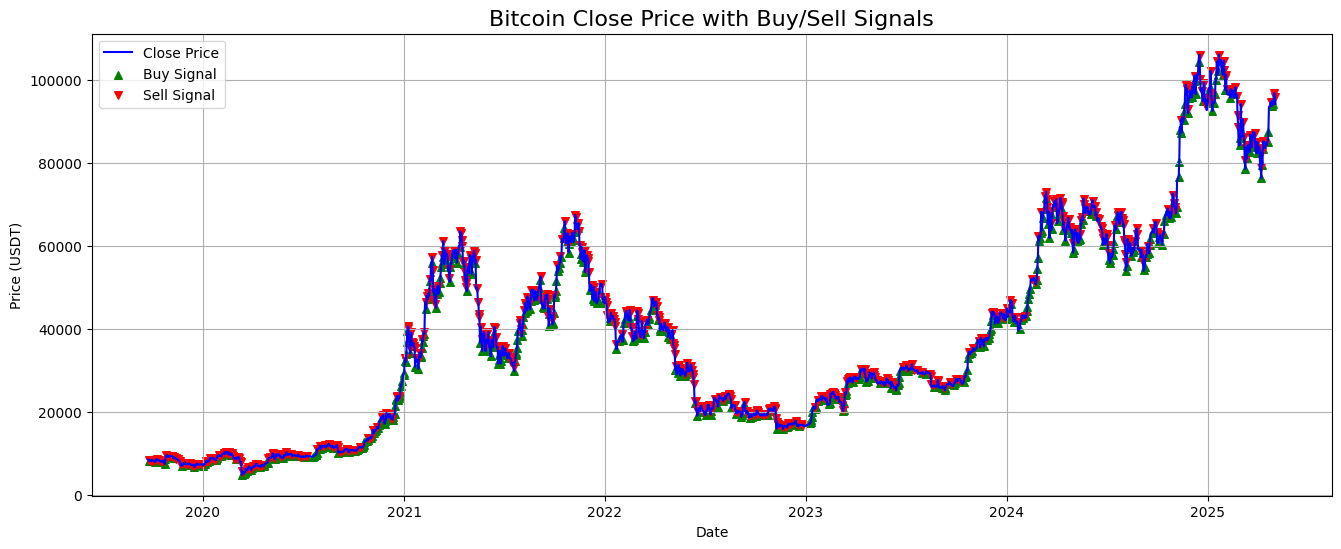

In [15]:
# Plot Close price
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')

# Mark the Targets
buy_signals = df[df['Target'] == 2]
sell_signals = df[df['Target'] == 0]

plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=30)
plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=30)

plt.title('Bitcoin Close Price with Buy/Sell Signals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid(True)
plt.show()


📈 **2. BTC, Gold, and Nasdaq Closing Prices**

This graph illustrates the closing prices of Bitcoin (BTC), Gold, and the Nasdaq stock market index over time. 
It allows us to compare the price trends of these three distinct asset classes, providing insights into how they have performed relative to each other.

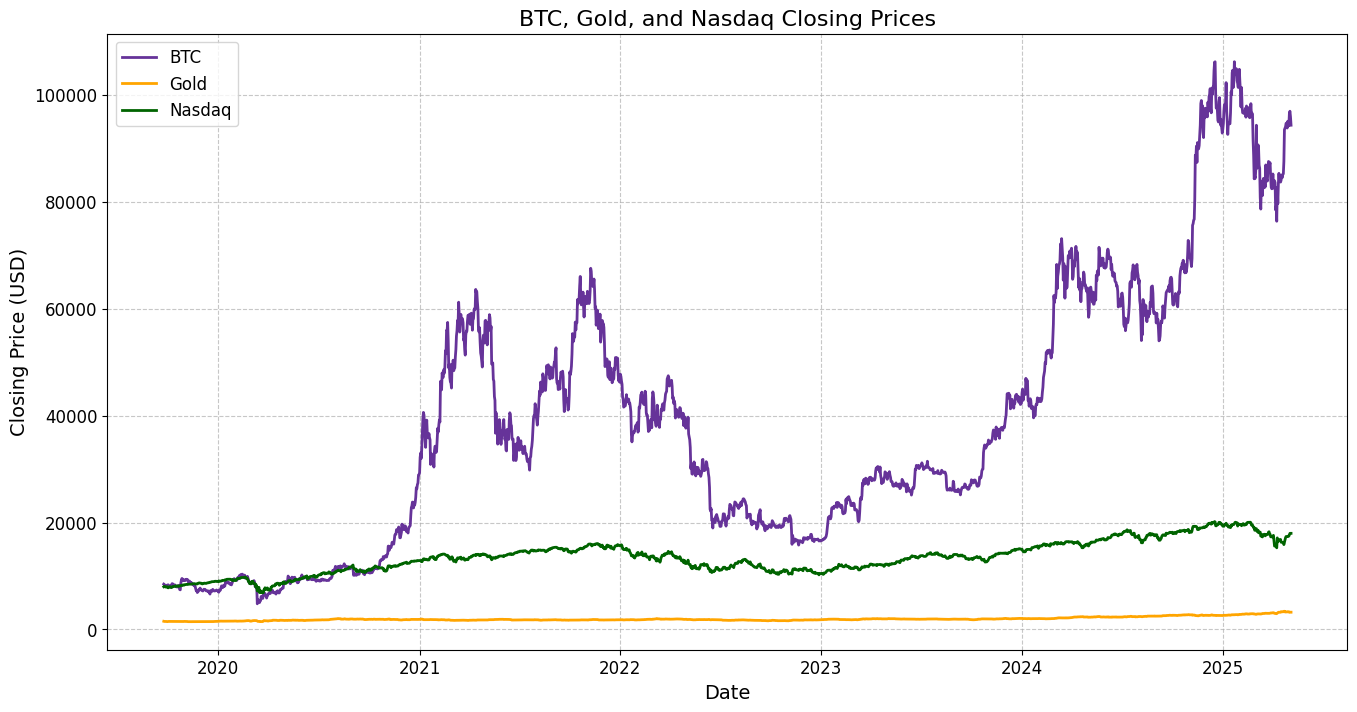

In [16]:
# Plotting
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], df['Close'], label='BTC', color='#663399', linewidth=2)
plt.plot(df['Date'], df['Gold_Close'], label='Gold', color='#FFA500', linewidth=2)
plt.plot(df['Date'], df['Nasdaq_Close'], label='Nasdaq', color='#006400', linewidth=2)

plt.title('BTC, Gold, and Nasdaq Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

📉 **3. MACD Indicator (MACD Line, Signal Line, Histogram)**

This graph displays the relationship between two exponential moving averages (EMAs) of the closing price.
The MACD Line (purple) and the Signal Line (orange) help identify potential buy or sell momentum, while the MACD Histogram (grey bars) shows the difference between them.

This visualization allows us to observe the periods when the MACD crosses above the signal line suggest bullish momentum, and crosses below suggest bearish momentum, which can be important features for predictive models.

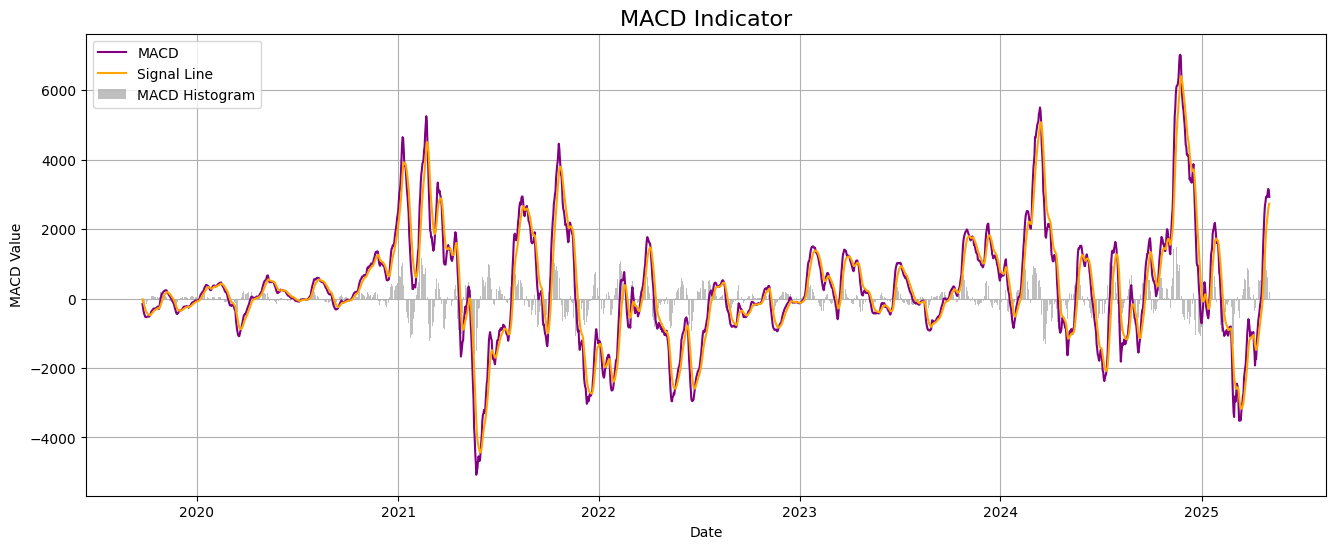

In [17]:
# Plot MACD and Signal Line
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['MACD'], label='MACD', color='purple')
plt.plot(df['Date'], df['Signal_Line'], label='Signal Line', color='orange')
plt.bar(df['Date'], df['MACD_Histogram'], label='MACD Histogram', color='grey', alpha=0.5)

plt.title('MACD Indicator', fontsize=16)
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()

📊 **4. RSI (Relative Strength Index) Over Time**

The RSI plot measures the speed and change of price movements.
The graph includes horizontal lines at 70 (overbought) and 30 (oversold) to indicate potential reversal points.

This visualization helps determine when Bitcoin may have been overbought (potential sell signal) or oversold (potential buy signal), providing additional insights into market sentiment that can support model training.

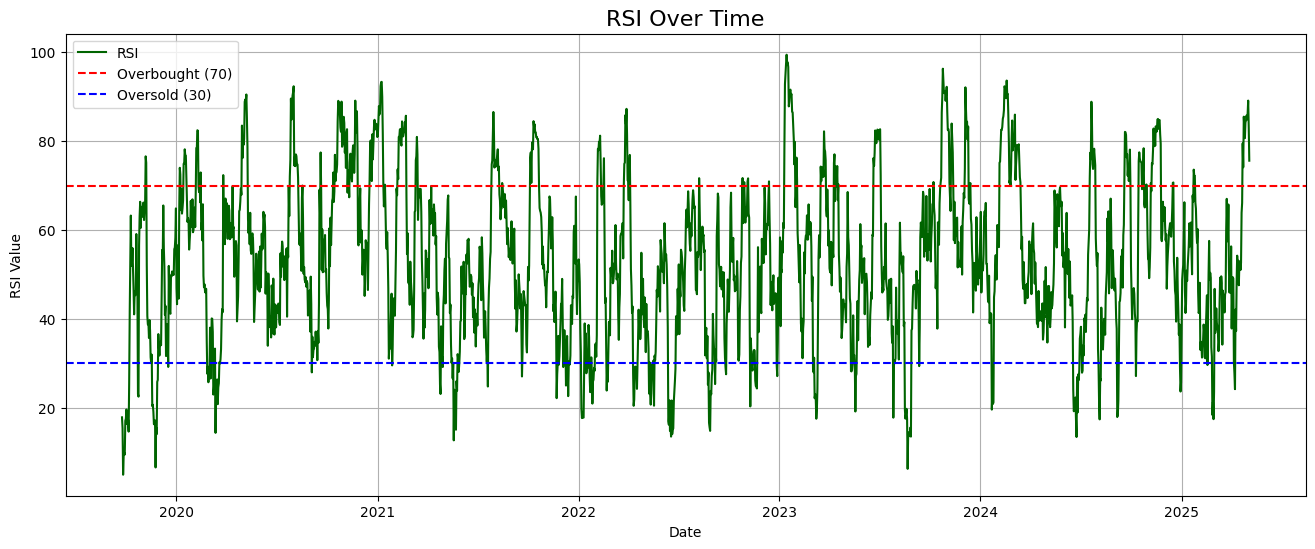

In [18]:
# Plot RSI
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['RSI'], label='RSI', color='darkgreen')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='blue', label='Oversold (30)')

plt.title('RSI Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()


📈**5. Close Price and Volume (Dual Axis Plot)**

This dual-axis plot simultaneously displays the Bitcoin closing price (blue line) and trading volume (grey bars) over time.

This visualization allows us to observe the volume spikes that often precede or coincide with significant price movements, so visualizing both metrics together can reveal underlying market dynamics that could influence price changes and thus impact model predictions.

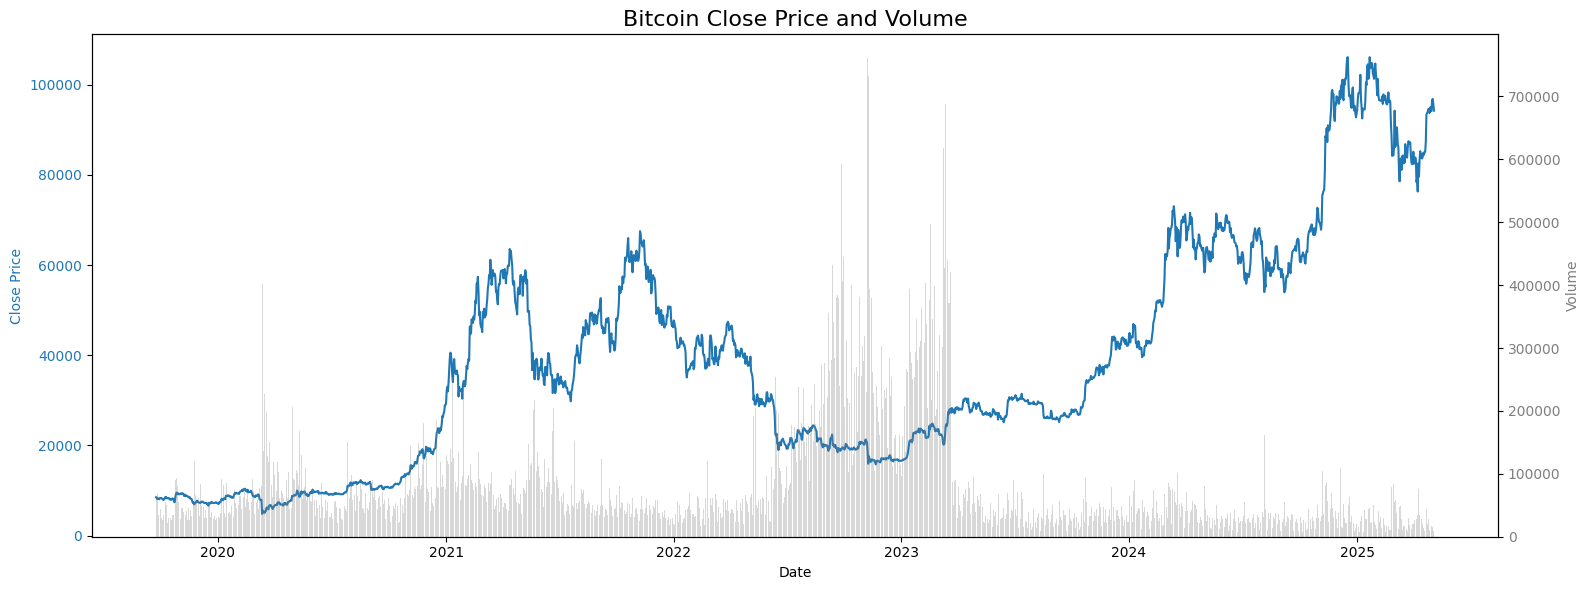

In [19]:
# Dual axis plot
fig, ax1 = plt.subplots(figsize=(16, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(df['Date'], df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instantiate a second y-axis sharing the same x-axis

color = 'tab:gray'
ax2.set_ylabel('Volume', color=color)
ax2.bar(df['Date'], df['Volume'], color=color, alpha=0.3)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Bitcoin Close Price and Volume', fontsize=16)
fig.tight_layout()
plt.show()


📊 **6.Distribution of Daily Returns**

This histogram illustrates the distribution of Bitcoin's daily returns over the dataset period. The daily return is calculated as the percentage change from open to close prices.

Understanding the return distribution is important, as it highlights the typical volatility range and identifies the frequency of extreme events, providing valuable context for setting realistic thresholds for trading decisions.

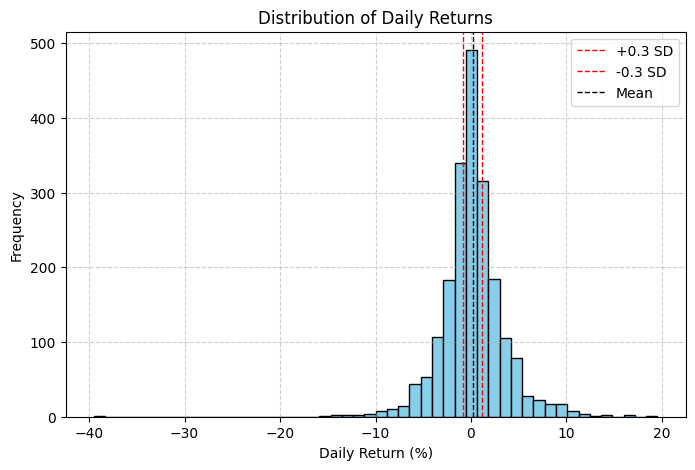

In [20]:
plt.figure(figsize=(8,5))
plt.hist(df['Close'].pct_change().dropna() * 100, bins=50, color='skyblue', edgecolor='black')

plt.axvline(x=mu+k*sigma, color='red', linestyle='--', linewidth=1, label=f'+{k} SD')
plt.axvline(x=mu-k*sigma, color='red', linestyle='--', linewidth=1, label=f'-{k} SD')
plt.axvline(x=mu, color='black', linestyle='--', linewidth=1, label='Mean')

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


The graph reveals that most daily returns are clustered around **0%**, indicating that small price changes are the norm for Bitcoin. However, the presence of long tails, especially towards negative returns, suggests occasional extreme losses.

🥧 **7. Target Distribution (Bar Chart of Sell / Hold / Buy Labels)**

This bar chart presents the distribution of the assigned target classes: Sell (0), Hold (1), and Buy (2).

A well-distributed target variable ensures the model has sufficient examples for each class, leading to better generalization and more accurate trading decisions.

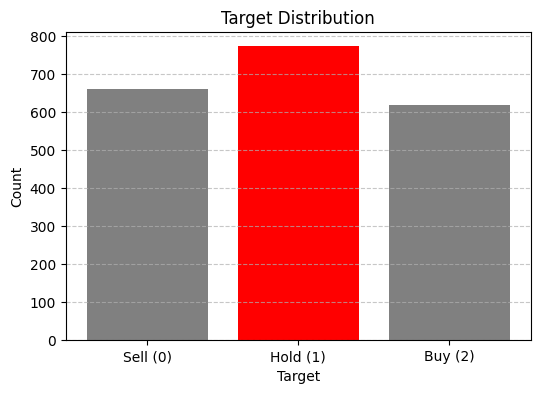

In [21]:
# Plot Target Distribution
target_counts = df['Target'].value_counts().sort_index()

# Set colors: Hold (1) = Red, others = Grey
colors = ['grey', 'red', 'grey']

plt.figure(figsize=(6,4))
bars = plt.bar(target_counts.index, target_counts.values, color=colors)

plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Sell (0)', 'Hold (1)', 'Buy (2)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


From the Target Distribution visualization, we can see that our dataset is **imbalanced dataset** (mostly **"Hold"** signals). So it can bias the model's learning process.

**8.Correlation Heatmap of Features**

This heatmap visualizes the pairwise Pearson correlation coefficients between key features such as price levels, technical indicators (MACD, RSI), volume, and funding rates. The intensity of the color represents the strength and direction of the correlation: darker shades indicate stronger positive or negative relationships. 

Understanding these correlations helps in identifying which features move together and may influence one another, ensuring that highly redundant features are recognized during model training.

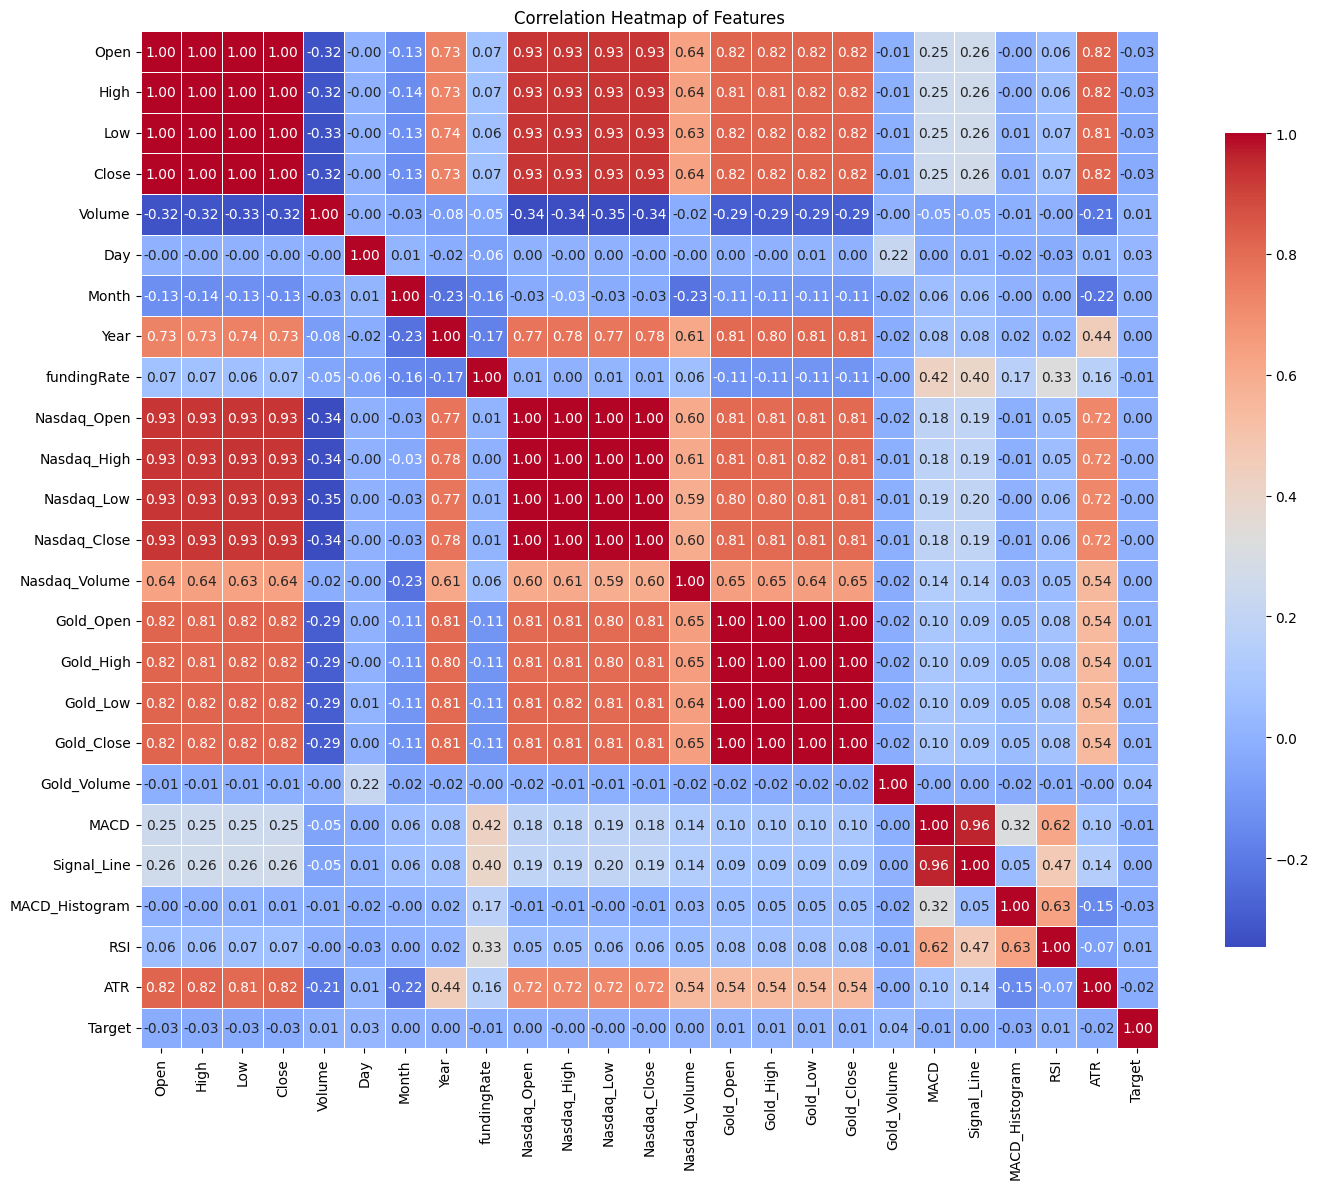

In [22]:
# Plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df.drop(['Date'], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()


The correlation heatmap shows **strong positive relationships among Bitcoin’s core price features (Open, High, Low, Close) and similarly among Nasdaq and Gold indicators**. Nasdaq features, in particular, show moderate to high correlation with Bitcoin prices, suggesting potential influence from the stock market. Gold features also have moderate correlations, reflecting shared macroeconomic factors. **Technical indicators like MACD, RSI, and ATR show modest correlations**, indicating additional but non-redundant value. Interestingly, the Target variable has low correlation with most features, suggesting a need for **non-linear models**. Volume and time-based features show little correlation, but may still offer useful patterns when combined with other engineered features.

<h1>Model</h1>

We will study compares four model types: Decision Tree, Random Forest, XGBoost, and LSTM

### Random Forest Classification Model

This model uses a Random Forest Classifier to predict Bitcoin price trends, classified into three categories based on the direction of next-day closing price changes. A pipeline is constructed with feature scaling and the classifier, and hyperparameters are optimized using GridSearchCV with 5-fold cross-validation. The model evaluates performance using accuracy, precision, recall, F1-score, and a confusion matrix to assess classification results.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'classifier__class_weight': 'balanced', 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Accuracy: 0.3170731707317073
Precision: 0.2982922134707176
Recall: 0.3170731707317073
F1: 0.26125502370978376


Text(0.5, 1.0, "Random Forest's Confusion Matrix")

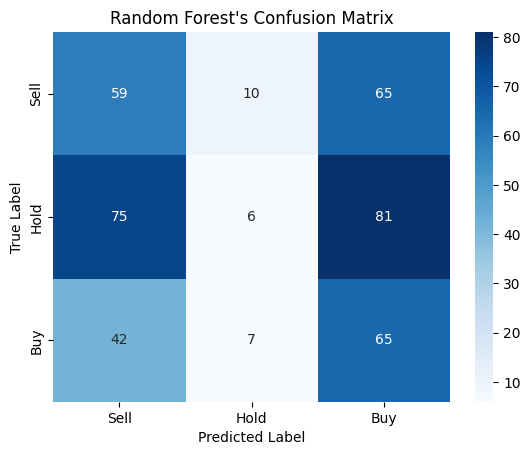

In [23]:
#using pipeline
#random forest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X=np.asarray(df.drop(['Date', 'Target'], axis=1))
y=np.asarray(df['Target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum samples in a leaf
    'classifier__class_weight': ["balanced"]  # Handling class imbalance
}
cv = KFold(n_splits=5)

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv =cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model from GridSearch
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

#Calculated model performance
print(grid_search.best_params_)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

cm = confusion_matrix(y_test, y_pred)
labels=['Sell', 'Hold','Buy']
sns.heatmap(cm, cmap='Blues', annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest's Confusion Matrix")

### Feature Importance Analysis

After training the Random Forest model, feature importance scores are extracted to identify which input variables contribute most to predicting Bitcoin price trends. This visualization highlights the top features ranked by their relative importance, helping to interpret the model and understand which market indicators influence predictions the most.

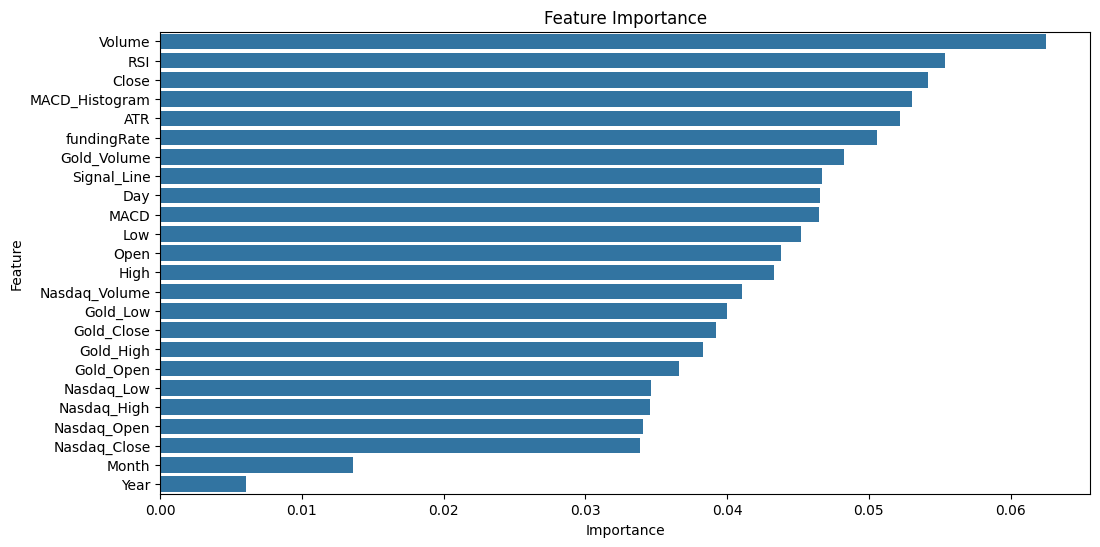

           Feature  Importance
4           Volume    0.062489
22             RSI    0.055383
3            Close    0.054164
21  MACD_Histogram    0.053054
23             ATR    0.052205
8      fundingRate    0.050555


In [24]:
# Get feature importance from the trained model
if 'classifier' in best_model.named_steps:
    rf_classifier = best_model.named_steps['classifier']
    importance = rf_classifier.feature_importances_

    # Create dataframe to hold feature importances
    features = df.drop(['Date', 'Target'], axis=1).columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Show feature importance plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title("Feature Importance")
    plt.show()

    # Print top 6 features
    print(importance_df.head(6))
else:
    print("Not a RandomForestClassifier")


### Decision Tree Classification Model

This section implements a Decision Tree Classifier to predict Bitcoin price trends based on future closing price movement. A pipeline is used with standardized inputs, and hyperparameter tuning is performed using GridSearchCV to optimize model depth, split criteria, and node constraints. Model performance is evaluated using accuracy, precision, recall, F1-score, and visualized with a confusion matrix to understand classification results.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Accuracy: 0.32926829268292684
Precision: 0.2434763989236417
Recall: 0.32926829268292684
F1: 0.20002901091380657


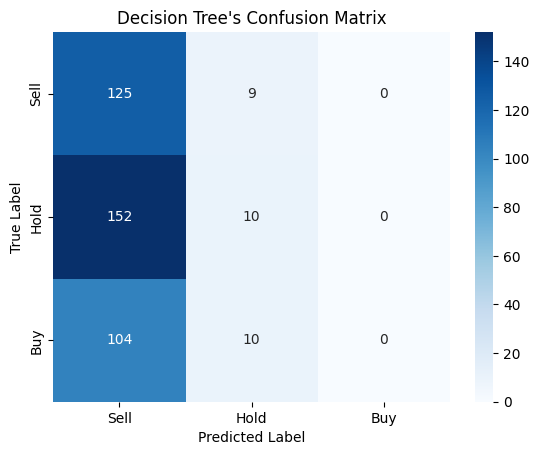

In [25]:
from sklearn.tree import DecisionTreeClassifier

pipeline.set_params(classifier=DecisionTreeClassifier(random_state=42))
grid_search.estimator = pipeline

# Hyperparameter grid for Decision Tree
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

grid_search.param_grid = param_grid
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Sell', 'Hold', 'Buy']
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree's Confusion Matrix")
plt.show()


### XGBoost Classification Model

This model applies the XGBoost Classifier to forecast Bitcoin price trends as a multi-class classification problem. The pipeline integrates input scaling with the XGBoost algorithm, leveraging advanced boosting techniques for better generalization. Hyperparameters such as learning rate, tree depth, and sampling strategies are optimized using GridSearchCV. The model’s effectiveness is assessed through accuracy, precision, recall, F1-score, and a confusion matrix to visualize prediction performance across classes.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Accuracy: 0.3195121951219512
Precision: 0.3524342626406155
Recall: 0.3195121951219512
F1: 0.279587582636545


Text(0.5, 1.0, "XGBoost's Confusion Matrix")

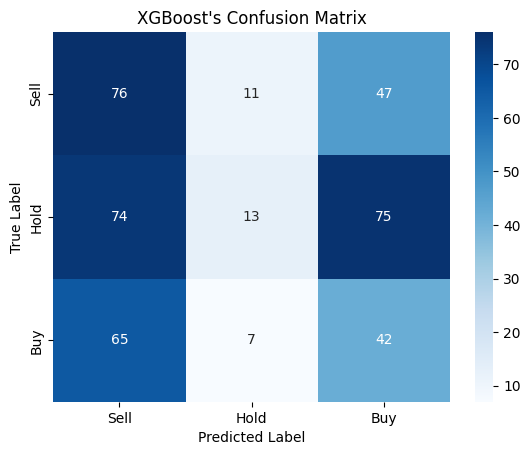

In [26]:
#XGBoost
from xgboost import XGBClassifier

pipeline.set_params(classifier = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', random_state=42))
grid_search.estimator = pipeline

param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Number of boosting rounds
    'classifier__max_depth': [3, 6, 9],  # Depth of trees
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'classifier__subsample': [0.7, 1.0],  # Fraction of samples per boosting round
    'classifier__colsample_bytree': [0.7, 1.0],  # Fraction of features per tree
}

grid_search.param_grid = param_grid
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
cm = confusion_matrix(y_test,y_pred)
labels=['Sell', 'Hold','Buy']
sns.heatmap(cm, cmap='Blues', annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost's Confusion Matrix")


### LSTM Deep Learning Model

This model employs a Long Short-Term Memory (LSTM) neural network to classify Bitcoin price trends based on historical market data. After scaling the features and reshaping the input to meet LSTM requirements, the model is built with stacked LSTM layers, dropout for regularization, and dense layers for final classification. The model is trained using the Adam optimizer and sparse categorical crossentropy loss. Performance is evaluated through accuracy, precision, recall, F1-score, and a confusion matrix to analyze prediction outcomes.

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3741 - loss: 1.0921 - val_accuracy: 0.3878 - val_loss: 1.0957
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4189 - loss: 1.0767 - val_accuracy: 0.4000 - val_loss: 1.0999
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4040 - loss: 1.0765 - val_accuracy: 0.3683 - val_loss: 1.1458
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4231 - loss: 1.0685 - val_accuracy: 0.3902 - val_loss: 1.1353
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4344 - loss: 1.0552 - val_accuracy: 0.3927 - val_loss: 1.0947
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4333 - loss: 1.0596 - val_accuracy: 0.3976 - val_loss: 1.0992
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4601 - loss: 1.0465 - val_accuracy: 0.3951 - val_loss: 1.2054
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4551 - loss: 1.0312 - val_accuracy: 0.3976 - 

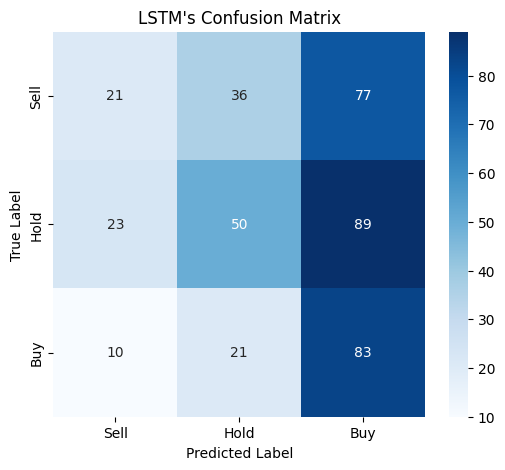

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Load & preprocess data
scaler = StandardScaler()
X = np.asarray(df.drop(['Date', 'Target'], axis=1))
y = np.asarray(df['Target'])

X_scaled = scaler.fit_transform(X)

# Reshape X for LSTM (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, shuffle=False)

# Define LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(50),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dense(3, activation='softmax')  # Assuming 3 classes: Sell, Hold, Buy
])

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Sell', 'Hold', 'Buy']

plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.title("LSTM's Confusion Matrix")
plt.show()



<h1>Conclusion</h1>

Results demonstrate that LSTM achieves the highest performance across all metrics, followed by XGBoost, Random Forest, and Decision Tree, respectively. As LSTM can better learn time sequences and deep data relationships, it is particularly suitable for application in decision support systems for cryptocurrency investment markets.